In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_file
import cv2
import os
from skimage import morphology
import math
import numpy as np
from tqdm import tqdm
import glob as glob
import SimpleITK as sitk
import json
import sys

def get_full_scan(folder_path):
    files_List = glob.glob(folder_path + '/**/*.dcm', recursive=True)
    itkimage = sitk.ReadImage(files_List[0])
    rows = int(itkimage.GetMetaData('0028|0010'))
    cols = int(itkimage.GetMetaData('0028|0011'))
    mn = 1000
    mx = 0
    for file in tqdm(files_List):
        itkimage = sitk.ReadImage(file)
        mn = np.min([mn, int(itkimage.GetMetaData('0020|0013'))])
        mx = np.max([mx, int(itkimage.GetMetaData('0020|0013'))])
    full_scan = np.ndarray(shape=(mx - mn + 1, rows, cols), dtype=float, order='F')
    new_list = np.ndarray(shape=(mx - mn + 1), dtype=object)
    for file in tqdm(files_List):
        img, n = dcm_image(file)
        n = int(n)
        full_scan[n - mn, :, :] = img[0, :, :]
        new_list[n-mn] = file
    return full_scan,new_list

def dcm_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    ins = float(itkimage.GetMetaData('0020|0013'))
    return numpyImage, ins


def CBCT_blurred(image, prev = 0,s=0):
    gray = np.zeros((image.shape[0], image.shape[1]) , dtype=int)
    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            if image[i,j] > -300 and image[i,j] < 500:
                gray[i,j] = 1
#     plt.imshow(gray , cmap = 'gray')
    ker1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
    ker2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    gray = cv2.morphologyEx(np.float32(gray), cv2.MORPH_CLOSE, ker1)
    gray = cv2.morphologyEx(np.float32(gray), cv2.MORPH_CLOSE, ker2)
    #plt.imshow(gray , cmap = 'gray')
    gray = gray>0
    gray = morphology.remove_small_objects(gray, min_size=200)
    #plt.imshow(gray , cmap = 'gray')
    gray = gray.astype(np.uint8)
    kernel = np.ones((30, 30), np.uint8)
    gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    gray = gray.astype(np.uint8)
    #plt.imshow(gray , cmap = 'gray')
    contours, hierarchy = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gray = cv2.drawContours(gray, contours,-1, 255, 10)
    #plt.imshow(gray , cmap = 'gray')
    gray[300:,:] = 0
    #plt.imshow(diff, cmap ='gray')
    seg = gray
    seg = np.where((seg==255),seg,0)
    z=0
    if not s==0:
        diff = np.subtract(seg,prev)
        diff = diff>1
        xx = int((diff.shape[1])/2)
        diff[:,0:(xx-100)] =0
        diff[:,(xx+100):] = 0
        diff = morphology.remove_small_objects(diff, min_size=500)
        if np.any(diff):
            for l in range(diff.shape[1]):
                for j in range(diff.shape[0]):
                    if diff[j,l]==True:
                        if np.any(prev[(j-10):(j+10),l]):
                            diff[j,l] = False
            seg = np.where((diff==True),0,seg)
            z=1
    blurred_img = cv2.GaussianBlur(image, (101, 101), 400)
    out = np.where((seg==255), blurred_img, image)
    out = out.astype(np.int16)
    if z==0:
        return out , seg
    else:
        return out, prev

def predictions(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    files_list = sorted(glob.glob((input_folder+ "/**/*.dcm"),recursive = True))
    output_list= []
    classUID = []
    annotations=[]
    initialdata = pydicom.dcmread(files_list[0])
    mode = str(initialdata.Modality)
    if (mode=='CT') or (mode=='ct'):
        i = 0
        scan, names = get_full_scan(input_folder)
        for i in tqdm(range(scan.shape[0])):
            name = names[i]
            img = scan[i, :, :]
            if i == 0:
                out, prev_img = CBCT_blurred(img)
            else:
                out, prev_img = CBCT_blurred(img, prev_img, s=1)
    
            out = out.astype(np.int16)
            dcmData = pydicom.dcmread(name)
            dcmData.PixelData = out.tobytes()
            classUID.append(str(dcmData.SOPClassUID))
            _, tail = os.path.split(name)
            des_path = os.path.join(output_folder, tail)
            output_list.append(des_path)
            annotations.append(None)
            dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
            dcmData.save_as(des_path)
            i = i + 1
    
    #mimeType = "application/dicom"
#     mimeType = []
#     for i in range(len(output_list)):
#         mimeType.append("application/dicom")
#     image=[]
#     print("in AI",len(classUID))
#     for i in range(len(classUID)):
#         image.append(None)
#     recommendation_string = {"finding": "dummy finding","conclusion":"dummy conclusion","recommendation":"dummy recommendation"} 
#     all_result={"output_list":output_list, "classUID":classUID, "mimeType":mimeType, "recommendation_string": recommendation_string,"annotations":annotations,"image":image}
#     with open(input_folder+"/values.json", "w") as outfile:
#         json.dump(all_result, outfile)
#     print(recommendation_string)
#     return all_result
    return 1



In [3]:
def get_full_scan_2(folder_path):
    files_List = glob.glob(folder_path + '/**/*.dcm', recursive=True)
    itkimage = sitk.ReadImage(files_List[0])
    rows = int(itkimage.GetMetaData('0028|0010'))
    cols = int(itkimage.GetMetaData('0028|0011'))
    mn = 1000
    mx = 0
    for file in tqdm(files_List):
        itkimage = sitk.ReadImage(file)
        mn = np.min([mn, int(itkimage.GetMetaData('0020|0013'))])
        mx = np.max([mx, int(itkimage.GetMetaData('0020|0013'))])
    full_scan = np.ndarray(shape=(mx - mn + 1, rows, cols), dtype=float, order='F')
    new_list = np.ndarray(shape=(mx - mn + 1), dtype=object)
    for file in tqdm(files_List):
        img, n = dcm_image(file)
        n = int(n)
        full_scan[n - mn, :, :] = img[0, :, :]

    return full_scan

In [4]:
import copy
def get_blurred_area(scan):
    plt.imshow(np.amax(scan, axis=0),'gray')
    plt.show()
    scann = copy.copy(scan)
    scann = np.where((scan==np.min(scan)),scan,np.min(scan))
    for i in range(scan.shape[0]):
        scann[i] = np.where((-150>scan[i]), scan[i] ,np.min(scan[i]))
        
    return scann

In [5]:
from skimage.metrics import structural_similarity

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [6]:
def main(ipath, opath): 
    predictions(ipath, opath)

33
20
00505


100%|█████████████████████████████████████████| 640/640 [16:03<00:00,  1.50s/it]


image similarity scan:  -0.034817853304066865
-0.8713804803374244
1.8425028331985278


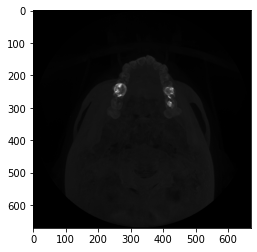

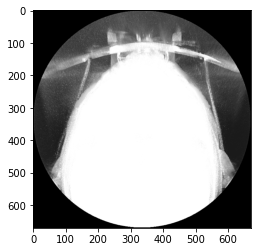

image similarity skin:  -0.034817853304066865
-5.0313441416245235
-10.371295275969278
00516


100%|█████████████████████████████████████████| 640/640 [15:35<00:00,  1.46s/it]


image similarity scan:  -0.05761319358835816
-0.9770409549314332
1.9896316302359411


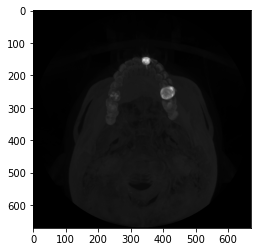

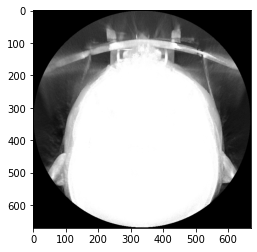

image similarity skin:  -0.05761319358835816
-4.726204906553886
-10.861358650420838
00518


100%|█████████████████████████████████████████| 640/640 [16:41<00:00,  1.56s/it]


image similarity scan:  -0.06282753695514341
-0.971359746609482
1.9180708362324563


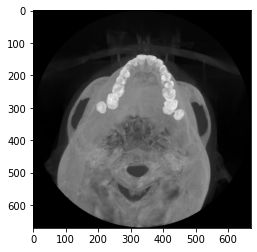

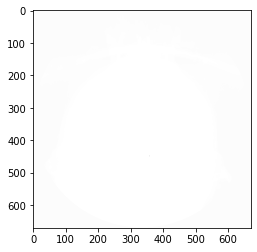

image similarity skin:  -0.06282753695514341
-5.276238404507061
-10.794857270299254
00553


100%|█████████████████████████████████████████| 640/640 [16:44<00:00,  1.57s/it]


image similarity scan:  -0.035064831992625146
-0.8744625039223609
1.7835654480629013


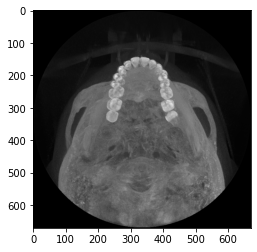

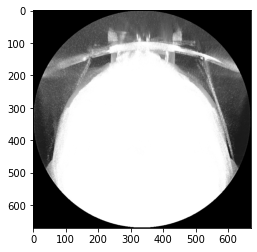

image similarity skin:  -0.035064831992625146
-4.733418808327454
-0.20588995065670865
00558


100%|█████████████████████████████████████████| 640/640 [16:46<00:00,  1.57s/it]


image similarity scan:  -0.0803579690273262
-0.9391001417856094
1.7220404942992296


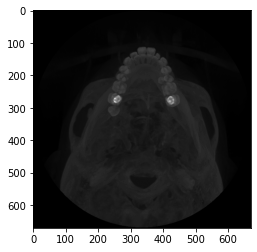

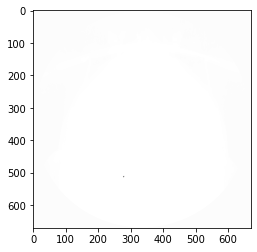

image similarity skin:  -0.0803579690273262
-4.757375831868317
-9.50649512864214
00572


100%|█████████████████████████████████████████| 640/640 [16:46<00:00,  1.57s/it]


image similarity scan:  -0.06953411504630629
-0.8770777866638024
1.8690611582948955


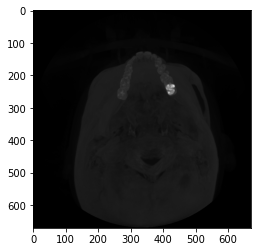

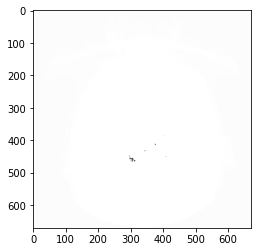

image similarity skin:  -0.06953411504630629
-4.856142069994672
-10.626584407754548
00620


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 124.35it/s]


image similarity scan:  -0.03893474817513905
-0.831807845885153
1.794424686721895


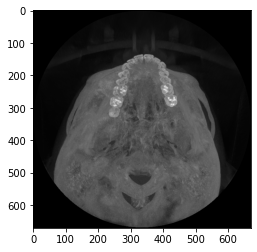

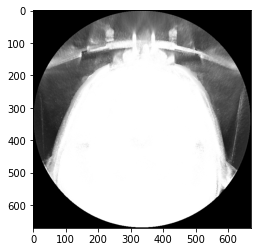

image similarity skin:  -0.03893474817513905
-4.762780865598558
-9.761666122095399
00624


100%|████████████████████████████████████████| 400/400 [00:02<00:00, 150.14it/s]


image similarity scan:  -0.05180546271197409
-0.6820327276788488
1.763001891389221


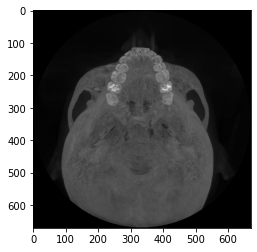

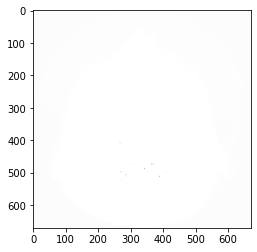

image similarity skin:  -0.05180546271197409
-4.701998459950435
-8.60696972263171
00660


100%|████████████████████████████████████████| 400/400 [00:02<00:00, 150.71it/s]


image similarity scan:  -0.052134907241428344
-0.6473668361301614
1.7274476841762973


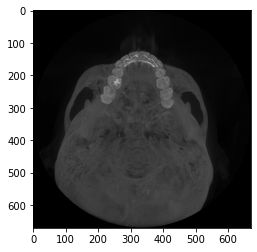

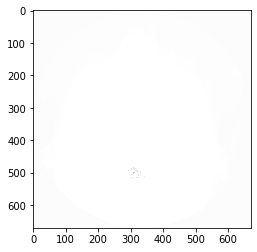

image similarity skin:  -0.052134907241428344
-4.621399693498811
-8.353774221846857
00690


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 124.18it/s]


image similarity scan:  -0.0354491342639054
-0.8534338455338548
1.9056094086230193


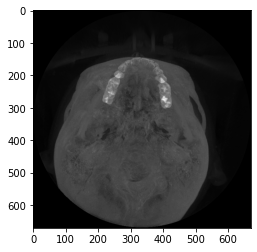

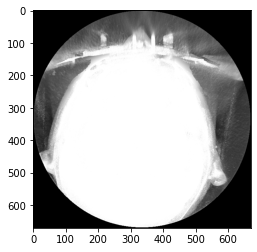

image similarity skin:  -0.0354491342639054
-4.470756021468011
-0.1605738713900652
00696


100%|████████████████████████████████████████| 400/400 [00:02<00:00, 150.13it/s]


image similarity scan:  -0.039251049513285376
-0.8387500675687195
1.9546239278040014


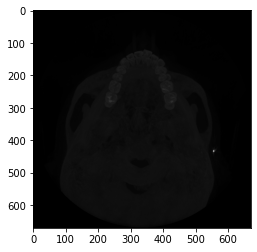

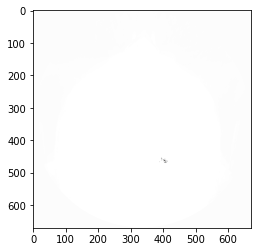

image similarity skin:  -0.039251049513285376
-4.735980452527697
-9.557865024998028
00759


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 124.67it/s]


image similarity scan:  -0.03710992961253872
-0.8749839032858456
1.9203235561108885


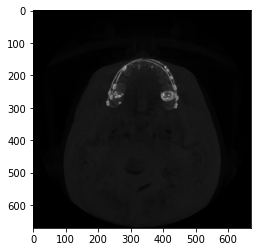

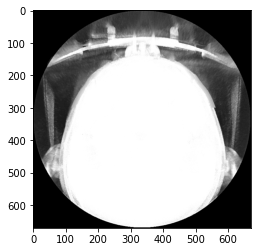

image similarity skin:  -0.03710992961253872
-4.807585409534945
-0.20831008763093825
00779


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 113.49it/s]


image similarity scan:  -0.0540883364272875
-0.6714164816809703
1.5791969579730154


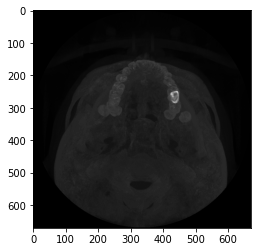

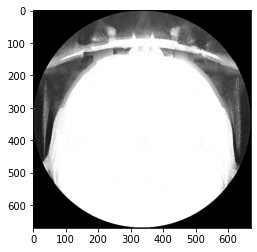

image similarity skin:  -0.0540883364272875
-4.578912583992072
-7.845389571815819
00813


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 126.24it/s]


image similarity scan:  -0.04856576371854931
-0.8660976185365639
1.786933751762411


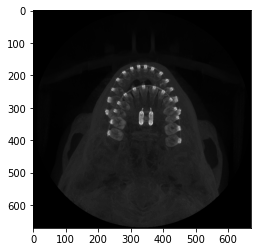

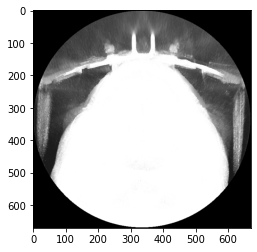

image similarity skin:  -0.04856576371854931
-5.463925958264255
-8.524233012457948
00847


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 126.10it/s]


image similarity scan:  -0.03767041626973168
-0.9175178874446243
1.9047171916178844


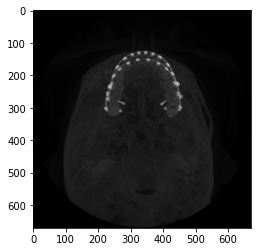

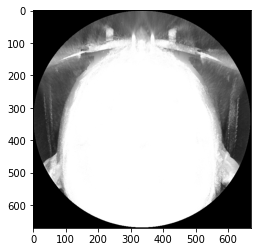

image similarity skin:  -0.03767041626973168
-4.281291892233351
-0.2817161867924541
00865


  0%|▏                                          | 2/640 [00:01<05:57,  1.79it/s]


error in:  00865
00904


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 125.84it/s]


image similarity scan:  -0.0328185007127345
-1.0400826722443992
2.2359833792483417


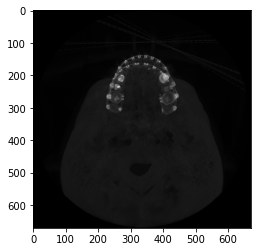

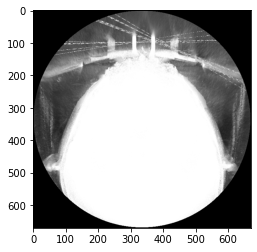

image similarity skin:  -0.0328185007127345
-4.579979885477594
-12.367154550750739
00905


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 125.54it/s]


image similarity scan:  -0.032653462180593285
-0.9701422930508026
1.960144490479477


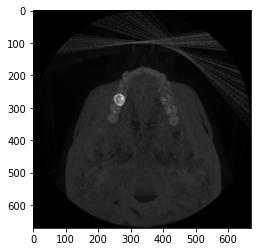

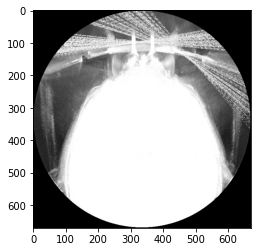

image similarity skin:  -0.032653462180593285
-4.882622172946523
-0.0012557530594942993
00963


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 125.35it/s]


image similarity scan:  -0.036854540229408414
-0.8605905011365425
1.7779927976777485


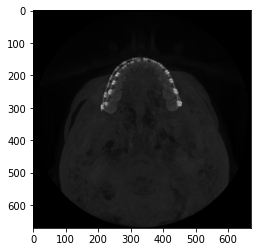

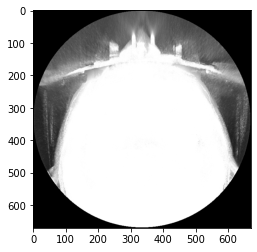

image similarity skin:  -0.036854540229408414
-4.927265245318027
-0.07513385026421583
00971


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 126.02it/s]


image similarity scan:  -0.040611430164982885
-0.8167226293977263
1.7724704989043707


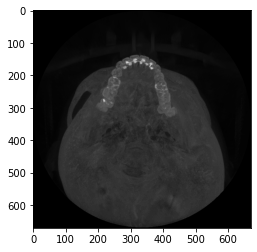

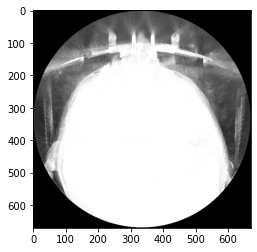

image similarity skin:  -0.040611430164982885
-4.992851624868444
-0.15847183386251937


In [7]:
ipath = "/home/azka/Face Anonymyzation Testing/CBCT/"
opath = "/home/minha/FARZEEN/face ann/face cbct/output/"
dirs = sorted(os.listdir(ipath))
print(len(dirs))
# dirs = dirs[:13]
dirs = dirs[13:]
print(len(dirs))
errors = []
smm = []
snr = []
snr1 = []

smm_s = []
snr_s = []
snr1_s = []
for d in dirs:
    try:
        print(d)
        input_p = ipath + d
        output_p = opath + d
        main(input_p, output_p)
        full_scan = get_full_scan_2(input_p)
        full_scan1 = get_full_scan_2(output_p)
        (score, diff) = structural_similarity(full_scan, full_scan1, full=True)
        print("image similarity scan: ", score)
        smm.append((d, score))
        sn = signaltonoise(full_scan, axis=None, ddof=0)
        print(sn)
        snr.append((d, sn))
        sn1 = signaltonoise(full_scan1, axis=None, ddof=0)
        snr1.append((d, sn1))
        print(sn1)

        scan_skin = get_blurred_area(full_scan)
        scan1_skin = get_blurred_area(full_scan1)
        (scores, diffs) = structural_similarity(scan_skin, scan1_skin, full=True)
        print("image similarity skin: ", score)
        smm_s.append((d, scores))
        sns = signaltonoise(scan_skin, axis=None, ddof=0)
        print(sns)
        snr_s.append((d, sn))
        sn1s = signaltonoise(scan1_skin, axis=None, ddof=0)
        print(sn1s)
        snr1_s.append((d, sn1s))
    except Exception as e:
        errors.append((d,e))
        print("error in: ", d)

In [ ]:
opath = (r"/home/minha/FARZEEN/face ann/face cbct/output/00203/")
full_scan2 = get_full_scan_2(opath)
scan1_skin = get_blurred_area(full_scan2)
sn1s = signaltonoise(scan1_skin, axis=None, ddof=0)
print(sn1s)

In [ ]:
files_List = glob.glob(r"/home/minha/FARZEEN/face ann/face cbct/output/00164/" + '/**/*.dcm', recursive=True)
len(files_List)

In [ ]:
d = dirs[13:]
d

In [ ]:
smm

In [ ]:
snr

In [ ]:
snr1 

In [ ]:
smm_s 

In [ ]:
snr_s 

In [ ]:
snr1_s 

In [ ]:
ipath = "/home/azka/Face Anonymyzation Testing/CBCT/00164/"
# ipath = "/home/minha/face/Bone_2_0/"
opath = "/home/minha/FARZEEN/face ann/face cbct/output/00164/"

In [ ]:
main(ipath, opath)

In [ ]:
files_list = sorted(glob.glob((ipath+ "/**/*.dcm"),recursive = True))
w = []
e = []
for f in files_list:
    try:
        ds = pydicom.dcmread(f)
        w.append(f)
    except:
        e.append(f)

In [ ]:
w

In [ ]:
len(w)

In [ ]:
len(e)

In [ ]:
e

In [ ]:
len(w)+len(e)

In [ ]:
from skimage.metrics import structural_similarity
import cv2
import numpy as np

In [ ]:
# folder_path1 = "/home/minha/fa/output/00865/"
full_scan1,_= get_full_scan(opath)
# folder_path = "/home/azka/Face Anonymyzation Testing/CBCT/00865/" # "/home/minha/face/Head_3_0/"
full_scan,_= get_full_scan(ipath)

In [ ]:
(score, diff) = structural_similarity(full_scan, full_scan1, full=True)
print("Image similarity", score)

In [ ]:
snr=signaltonoise(full_scan, axis=None, ddof=0)
print(snr)

In [ ]:
snr=signaltonoise(full_scan1, axis=None, ddof=0)
print(snr)

In [ ]:
scan_skin = get_blurred_area(full_scan)
scan1_skin = get_blurred_area(full_scan1)

In [ ]:
(score, diff) = structural_similarity(scan_skin, scan1_skin, full=True)
print("Image similarity", score)

In [ ]:
snr=signaltonoise(scan_skin, axis=None, ddof=0)
print(snr)

In [ ]:
snr=signaltonoise(scan1_skin, axis=None, ddof=0)
print(snr)

In [ ]:
dirs = os.listdir("/home/azka/Face Anonymyzation Testing/CBCT/")
print(len(dirs))
dirs[1]

In [ ]:
scann = full_scan
print(scann.shape)
plt.imshow(scann[100],'gray')
plt.show()
scannn = np.where((scann==np.min(scann)),scann,np.min(scann))
print(scannn.shape)
plt.imshow(scannn[100])
plt.show()
scannn[100] = np.where((-120>scann[100]), scann[100] ,np.min(scann[100]))
plt.imshow(scannn[100],'gray')

In [ ]:
plt.imshow(full_scan[100],'gray')
plt.show()
plt.imshow(full_scan1[100],'gray')

In [ ]:
v = full_scan[100]
print(np.min(v), np.max(v))
print(v[10][250])
print(v[100][250])
plt.imshow(v,'gray')

In [ ]:
x = np.where((-500>v),v,-1024)
plt.imshow(x,'gray')
plt.show()
print(np.min(x), np.max(x))
y = np.where((v<-150), v , -1024)
plt.imshow(y,'gray')
plt.show()

In [ ]:
v = full_scan1[100]
print(np.min(v), np.max(v))
print(v[10][250])
print(v[100][250])

x = np.where((-350>v),v,-1024)
plt.imshow(x,'gray')
plt.show()
y = np.where((v<150), x , -1024)
plt.imshow(y,'gray')
plt.show()

In [ ]:
image = full_scan[100,:,:]
gray = np.zeros((image.shape[0], image.shape[1]) , dtype=int)
for i in range(gray.shape[0]):
    for j in range(gray.shape[1]):
        if image[i,j] < -300 and image[i,j] > 500:
            gray[i,j] = 1

In [ ]:
plt.imshow(image,'gray')
plt.show()
plt.imshow(gray,'gray')
plt.show

In [ ]:
ker1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
ker2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
gray = cv2.morphologyEx(np.float32(gray), cv2.MORPH_CLOSE, ker1)
gray = cv2.morphologyEx(np.float32(gray), cv2.MORPH_CLOSE, ker2)
plt.imshow(gray , cmap = 'gray')
plt.show()
gray = gray>0
gray = morphology.remove_small_objects(gray, min_size=200)
plt.imshow(gray , cmap = 'gray')
plt.show()
gray = gray.astype(np.uint8)
kernel = np.ones((30, 30), np.uint8)
gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
gray = gray.astype(np.uint8)
plt.imshow(gray , cmap = 'gray')
plt.show()
contours, hierarchy = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
gray = cv2.drawContours(gray, contours,-1, 255, 10)
plt.imshow(gray , cmap = 'gray')
plt.show()
gray[300:,:] = 0
# plt.imshow(diff, cmap ='gray')
# plt.show()
seg = gray
seg = np.where((seg==255),seg,0)
plt.imshow(seg,'gray')
plt.show()
blurred_img = cv2.GaussianBlur(image, (101, 101), 400)
plt.imshow(blurred_img,'gray')
plt.show()
out = np.where((seg==255), blurred_img, image)
plt.imshow(out,'gray')
plt.show()
out = out.astype(np.int16)
plt.imshow(out,'gray')
plt.show()

In [ ]:
t = np.where((seg==255), v,-1024)
plt.imshow(t,'gray')

In [ ]:
z=full_scan1[100]
t = np.where((seg==255), z,-1024)
plt.imshow(t,'gray')

In [ ]:
ones = np.where(1, seg, 0)

In [ ]:
gray[ones]=0

In [ ]:
plt.imshow(ones,'gray')